# Fraud Detection using Autoencoders and Deep Learning

## Project Overview
This project aims to detect fraudulent transactions using deep learning techniques. We utilize **Autoencoders** for dimensionality reduction and train a **Neural Network** classifier on the encoded features. The project includes **hyperparameter tuning**, deployment via **Streamlit**, and an API endpoint using **FastAPI**.

In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, accuracy_score

In [3]:
## Importing  dataset
train_df = pd.read_csv("/kaggle/input/icc-dataset/ieee-fraud-detection/train_transaction.csv")
train_df2 = pd.read_csv("/kaggle/input/icc-dataset/ieee-fraud-detection/train_identity.csv")

In [4]:
# Merge both dataset on "Transaction ID" column
df = train_df.merge(train_df2, on="TransactionID", how="left")

In [5]:
print(df.shape)


(590540, 434)


In [6]:
import warnings
warnings.filterwarnings("ignore")

In [7]:
df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M


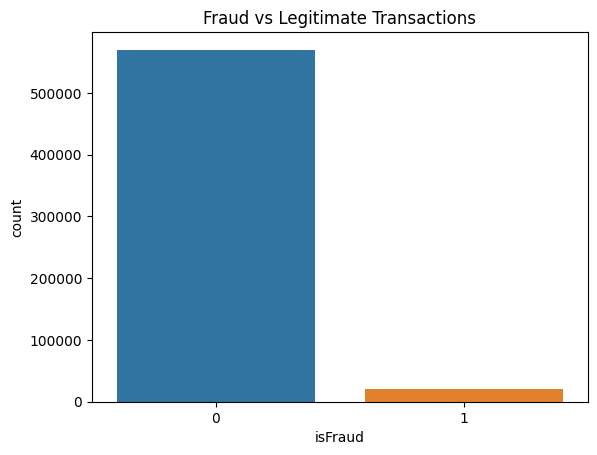

In [8]:
## checking for class imbalance
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x="isFraud", data=df)
plt.title("Fraud vs Legitimate Transactions")
plt.show()

In [9]:
# Drop columns with more than 50% missing values
df.dropna(thresh=len(df) * 0.5, axis=1, inplace=True)

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 220 entries, TransactionID to V321
dtypes: float64(207), int64(4), object(9)
memory usage: 991.2+ MB


In [10]:
# Total missing values in training dataset
df.isnull().sum().sum()

14036680

In [11]:
for col in df.select_dtypes(include=['object']).columns:
    df[col].fillna("missing", inplace = True)

In [12]:
# New total missing values
df.isnull().sum().sum()

12674972

In [13]:
# Handle missing values with integer or float values
for col in df.select_dtypes(include=['int64', 'float64']).columns:
    df[col].fillna(df[col].median(), inplace = True)

In [15]:
df.isnull().sum()

TransactionID     0
isFraud           0
TransactionDT     0
TransactionAmt    0
ProductCD         0
                 ..
V317              0
V318              0
V319              0
V320              0
V321              0
Length: 220, dtype: int64

In [16]:
df.isnull().sum().sum()

0

In [14]:
# Encode categorical variables
from sklearn.preprocessing import LabelEncoder

# Apply label encoding to categorical variables in training dataset
label_encoders = {}
for col in df.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le 

df.head()

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,V312,V313,V314,V315,V316,V317,V318,V319,V320,V321
0,2987000,0,86400,68.5,4,13926,361.0,150.0,1,142.0,...,0.0,0.0,0.0,0.0,0.0,117.0,0.0,0.0,0.0,0.0
1,2987001,0,86401,29.0,4,2755,404.0,150.0,2,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2987002,0,86469,59.0,4,4663,490.0,150.0,4,166.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2987003,0,86499,50.0,4,18132,567.0,150.0,2,117.0,...,135.0,0.0,0.0,0.0,50.0,1404.0,790.0,0.0,0.0,0.0
4,2987004,0,86506,50.0,1,4497,514.0,150.0,2,102.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
import joblib
joblib.dump(le, "labelencoder.pkl")

['labelencoder.pkl']

In [18]:
df.shape

(590540, 220)

In [19]:
## separate features
X = df.drop(columns = ["TransactionID","isFraud"])
y = df["isFraud"]

In [30]:
feature_names = X.columns.tolist()

In [32]:
with open("features.txt", "w") as f:
    f.write("\n".join(feature_names))

In [37]:
X["P_emaildomain"]

0         31
1         16
2         36
3         54
4         16
          ..
590535    31
590536    16
590537    16
590538     2
590539    16
Name: P_emaildomain, Length: 590540, dtype: int64

In [20]:
# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

    

In [57]:
import joblib
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [21]:
#Handling class imbalance with SMOTE
from imblearn.over_sampling import SMOTE

smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, y)

In [22]:
X_resampled.shape

(854815, 218)

In [23]:
y_resampled

0         0
1         0
2         0
3         0
4         0
         ..
854810    1
854811    1
854812    1
854813    1
854814    1
Name: isFraud, Length: 854815, dtype: int64

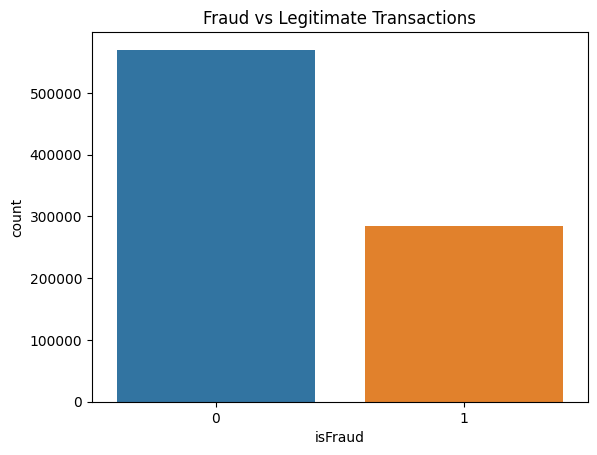

In [24]:
sns.countplot(x = y_resampled)
plt.title("Fraud vs Legitimate Transactions")
plt.show()

In [25]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.15, random_state=107)

In [41]:
input_dim = X_train.shape[1]

#Train an Autoencoder to Reduce Dimensionality
def build_autoencoder():
    input_layer = Input(shape=(input_dim,))
    encoded = Dense(128, activation="relu")(input_layer)
    encoded = Dense(64, activation="relu")(encoded)
    encoded = Dense(32, activation="relu")(encoded)  # Compressed representation
    decoded = Dense(64, activation="relu")(encoded)
    decoded = Dense(128, activation="relu")(decoded)
    decoded = Dense(input_dim, activation="sigmoid")(decoded)
    autoencoder = Model(input_layer, decoded)
    autoencoder.compile(optimizer="adam", loss="mse")
    return autoencoder
autoencoder = build_autoencoder()
autoencoder.fit(X_train, X_train, epochs=10, batch_size=64, validation_split=0.2)

Epoch 1/10
9083/9083 ━━━━━━━━━━━━━━━━━━━━ 21s 2ms/step - loss: 1.1972 - val_loss: 1.1902
Epoch 2/10
9083/9083 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 1.1756 - val_loss: 1.1850
Epoch 3/10
9083/9083 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 1.1907 - val_loss: 1.1815
Epoch 4/10
9083/9083 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 1.1661 - val_loss: 1.1816
Epoch 5/10
9083/9083 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 1.1510 - val_loss: 1.1798
Epoch 6/10
9083/9083 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 1.1498 - val_loss: 1.1753
Epoch 7/10
9083/9083 ━━━━━━━━━━━━━━━━━━━━ 17s 2ms/step - loss: 1.1594 - val_loss: 1.1748
Epoch 8/10
9083/9083 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 1.1590 - val_loss: 1.1748
Epoch 9/10
9083/9083 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 1.1542 - val_loss: 1.1737
Epoch 10/10
9083/9083 ━━━━━━━━━━━━━━━━━━━━ 16s 2ms/step - loss: 1.1488 - val_loss: 1.1738


In [42]:
# Extract Encoded Features
encoder = Model(autoencoder.input, autoencoder.layers[3].output)
X_train_encoded = encoder.predict(X_train)
X_test_encoded = encoder.predict(X_test)

22706/22706 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step


In [58]:
joblib.dump(autoencoder, "autoencoder.keras")

['autoencoder.keras']

In [43]:
X_train_encoded.shape

(726592, 32)

In [44]:
y_train.shape

(726592,)

In [45]:
# Train a Deep Learning Model with hyperparameter tuning
def build_classifier(learning_rate=0.001):
    model = Sequential([
        Dense(64, activation="relu", input_shape=(X_train_encoded.shape[1],)),
        Dropout(0.3),
        Dense(32, activation="relu"),
        Dropout(0.3),
        Dense(1, activation="sigmoid")
    ])
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])
    return model

In [46]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam
# Alternative Hyperparameter Tuning: Randomized Search & Early Stopping
learning_rates = [0.001, 0.0005, 0.0001]
epochs_list = [10, 20]
batch_sizes = [32, 64, 128]

best_model = None
best_accuracy = 0
best_params = {}

checkpoint = ModelCheckpoint("fraud_classification_{epoch:02d}_{val_accuracy:.3f}.keras",
                             mode = "max", monitor='val_accuracy', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True)

for lr in learning_rates:
    for epochs in epochs_list:
        for batch_size in batch_sizes:
            classifier = build_classifier(learning_rate=lr)
            history = classifier.fit(X_train_encoded, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2, verbose=0, callbacks=[early_stopping, checkpoint])
            y_pred = (classifier.predict(X_test_encoded) > 0.5).astype(int)
            acc = accuracy_score(y_test, y_pred)
            print(f"LR: {lr}, Epochs: {epochs}, Batch: {batch_size}, Accuracy: {acc:.4f}")
            if acc > best_accuracy:
                best_accuracy = acc
                best_model = classifier
                best_params = {'learning_rate': lr, 'epochs': epochs, 'batch_size': batch_size}

print("Best Parameters: ", best_params)


Epoch 1: val_accuracy improved from -inf to 0.79378, saving model to fraud_classification_01_0.794.keras

Epoch 2: val_accuracy improved from 0.79378 to 0.80342, saving model to fraud_classification_02_0.803.keras

Epoch 3: val_accuracy improved from 0.80342 to 0.81062, saving model to fraud_classification_03_0.811.keras

Epoch 4: val_accuracy improved from 0.81062 to 0.81154, saving model to fraud_classification_04_0.812.keras

Epoch 5: val_accuracy improved from 0.81154 to 0.81581, saving model to fraud_classification_05_0.816.keras

Epoch 6: val_accuracy did not improve from 0.81581

Epoch 7: val_accuracy did not improve from 0.81581

Epoch 8: val_accuracy improved from 0.81581 to 0.81689, saving model to fraud_classification_08_0.817.keras

Epoch 9: val_accuracy improved from 0.81689 to 0.81898, saving model to fraud_classification_09_0.819.keras

Epoch 10: val_accuracy did not improve from 0.81898
4007/4007 ━━━━━━━━━━━━━━━━━━━━ 5s 1ms/step
LR: 0.001, Epochs: 10, Batch: 32, Accura

In [48]:
from tensorflow.keras.models import load_model
best_model = load_model("/kaggle/working/fraud_classification_09_0.819.keras")

In [49]:
# Model Evaluation
y_pred = (best_model.predict(X_test_encoded) > 0.5).astype(int)
print(classification_report(y_test, y_pred))
print(f"Best Model Accuracy: {best_accuracy:.4f}")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

4007/4007 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
              precision    recall  f1-score   support

           0       0.82      0.93      0.87     85426
           1       0.80      0.60      0.69     42797

    accuracy                           0.82    128223
   macro avg       0.81      0.76      0.78    128223
weighted avg       0.82      0.82      0.81    128223

Best Model Accuracy: 0.8183
Accuracy: 0.8183


In [52]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Non-Fraud', 'Fraud'], yticklabels=['Non-Fraud', 'Fraud'])
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

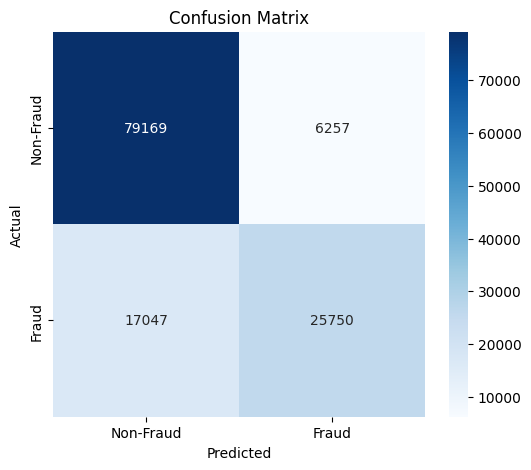

In [53]:
plot_confusion_matrix(y_test, y_pred)

In [54]:
# ROC Curve
def plot_roc_curve(y_true, y_scores):
    fpr, tpr, _ = roc_curve(y_true, y_scores)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

4007/4007 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step


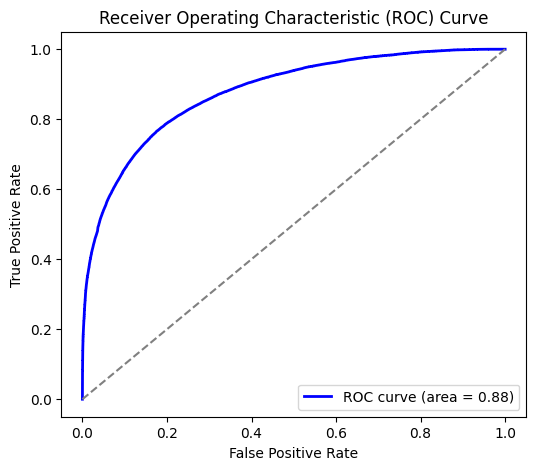

In [55]:
plot_roc_curve(y_test, best_model.predict(X_test_encoded))

In [56]:
# Print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.82      0.93      0.87     85426
           1       0.80      0.60      0.69     42797

    accuracy                           0.82    128223
   macro avg       0.81      0.76      0.78    128223
weighted avg       0.82      0.82      0.81    128223

